In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def get_linescan_data(folder, sgRNA, time_d, n_edges=5):
    '''
    Read in linescan data and annotate with meta data
    
    Inputs:
    -------
        - folder: the folder that contains the linescan output csv file
        - sgRNA: which sgRNA was used for the treatment of this group
        - time_d: how many days after culture the samples were collected
        - n_edges: how many edges were quantified per sample
        
    Outputs:
        - df: pandas data frame with linescan data and annotation data
        
    '''
    
    linescan_files = glob.glob(os.path.join(folder, '*.txt'))

    if len(linescan_files) > 1:
        print('There are more than 1 output file in', folder)
        print('The newest one will be used.')
        linescan_files = sorted(linescan_files,
                                key = os.path.getmtime)
        
    df = pd.read_csv(linescan_files[-1])
    
    # annotate data
    assert len(df) % 5 == 0
    n_organoids = int(len(df) / 5)
    
    sample_ids = []
    organoid_ids = []
    for i in range(n_organoids):
        for j in range(n_edges):
            sample_ids.append(sgRNA + '_' + str(i+1))
            organoid_ids.append( str(i+1) )
    
    df['sample_id'] = sample_ids
    df['organoid_id'] = organoid_ids
    df['sgRNA'] = [sgRNA]*len(df)
    df['time_d'] = time_d
    df['groups'] = [sgRNA + '_' + str(time_d)]*len(df)
    
    return df

In [3]:
input_folder = '../data/190503-Serpinh1-KO-Col4-IF/line-scans-across-BM/'
folders = glob.glob(os.path.join(input_folder, '*line-scan-output' + os.path.sep))

In [9]:
dfs = []
for folder in folders:
    if folder.endswith(os.path.sep):
        folder = folder[:-1]
    sgRNA = os.path.basename(folder).split('-')[4]
    time_d = 4
    dfs.append(get_linescan_data(folder, sgRNA, time_d, n_edges=5))

In [10]:
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

In [11]:
df.tail()

,file_name,id,Col4_AUC,Col4_peak_height,z_position,sample_id,organoid_id,sgRNA,time_d,groups
140,6-z-20,1,4412.8010,264.1396,1,230_6,6,230,4,230_4
141,6-z-20,2,-352.2645,149.3963,1,230_6,6,230,4,230_4
142,6-z-20,3,10439.8835,747.3499,1,230_6,6,230,4,230_4
143,6-z-20,4,5193.4890,560.5394,1,230_6,6,230,4,230_4
144,6-z-20,5,16010.0167,1289.1151,1,230_6,6,230,4,230_4


In [12]:
# normalize to the average of control
ctrl_average = df[df.sgRNA=='188'].Col4_peak_height.mean()
df['Col4_normed'] = df['Col4_peak_height'] / ctrl_average

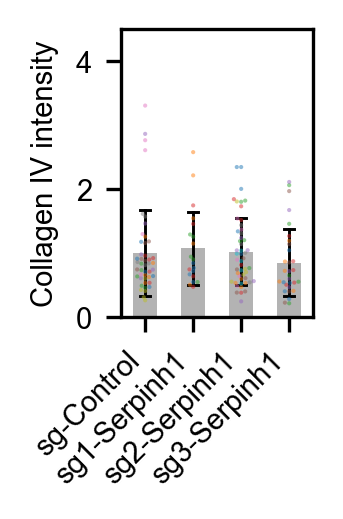

In [29]:
# Swarm plot of 4 categories

outputPrefix = '190503-IF-Col4-across-BM-sg-Serpinh1-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 0.8
fig_height = 1.2

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='sgRNA', y='Col4_normed', data=df,
                   hue='organoid_id',
#                    palette={'1': 'red', '2': 'green', '3': 'blue', '4': yellow', '5': 'purple'},
                   # color="blue",
                   alpha=0.5,
                   size=1.0 )

ax = sns.barplot(x='sgRNA', y='Col4_normed', data=df,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

# plt.ylim(0, 1.7)
plt.ylim(0, 4.5)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('Collagen IV intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Serpinh1', 'sg2-Serpinh1', 'sg3-Serpinh1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [15]:
for i in df.sgRNA.unique():
    print(i, 'n =', len(df[df.sgRNA==i]))

188 n = 45
228 n = 20
229 n = 50
230 n = 30


In [16]:
tukeyTest(df.Col4_normed, df.sgRNA)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   188    228   0.0793    0.9 -0.3308 0.4894  False
   188    229   0.0246    0.9  -0.289 0.3381  False
   188    230  -0.1449 0.6983 -0.5046 0.2148  False
   228    229  -0.0547    0.9 -0.4585  0.349  False
   228    230  -0.2242 0.5441 -0.6647 0.2164  False
   229    230  -0.1694  0.585 -0.5219  0.183  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.9        0.6983394  0.9        0.5441151  0.58498304]


In [17]:
folders[0]

'../data/190503-Serpinh1-KO-Col4-IF/line-scans-across-BM/190503-Cas9-E13p5epi-LV-188-antiHSP47-405-anti-Col4-647-temp-BM-line-scan-output/'

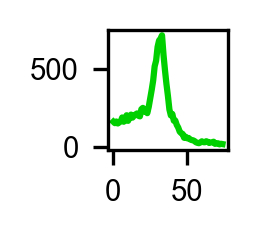

In [28]:
# Example linescan profile

raw_BM_linescan_files = glob.glob(os.path.join(folders[0], 'raw-BM-linescan-profile-record', '*a6int.txt'))
i = 5
df_example = pd.read_csv(raw_BM_linescan_files[i])

df_example['pixels'] = list(range(len(df_example)))

outputPrefix = '190503-Col4-across-BM-line-scan-example'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.5
fig_height=0.5
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plt.plot(df_example.pixels, df_example.Col4_intensity, color='#00d000')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [30]:
for i in df.sgRNA.unique():
    print(i, 'n =', len(df[df.sgRNA==i]))

188 n = 45
228 n = 20
229 n = 50
230 n = 30
